In [1]:
from scipy import signal
import numpy as np

import matplotlib
matplotlib.use('nbagg')
from pylab import rcParams
rcParams['figure.figsize'] = 9, 4
import matplotlib.pyplot as plt
import scipy

from scipy.fftpack import fft, ifft
import pandas as pd
%load_ext autoreload
%autoreload 2
import sys
import copy

from pyha import Hardware, simulate, sims_close, Complex, resize, hardware_sims_equal
from pathlib import Path
from data import load_iq
sys.path.insert(0,'/home/gaspar/git/pyhacores/under_construction/fft/')
from under_construction.fft.bit_reversal_fftshift import BitReversal
from under_construction.fft.conjmult import ConjMult
from under_construction.fft.fft_core import R2SDF
from under_construction.fft.windower import Windower
from under_construction.fft.avg_decimate import AvgDecimate
from under_construction.fft.spectrogram import Spectrogram
from under_construction.fft.bitreversal_fftshift_decimate import BitreversalFFTshiftDecimate
from under_construction.fft.packager import Packager, DataWithIndex, unpackage, package

def imshow(im):
    from skimage.exposure import exposure
    p2, p98 = np.percentile(im, (2, 98))
    im = exposure.rescale_intensity(im, in_range=(p2, p98))

    
    plt.imshow(im, interpolation='nearest', aspect='auto', origin='lower')
    plt.tight_layout()
    plt.show()
    
    
def snr(pure, noisy):
    sig_pow = np.mean(np.abs(pure))
    error = np.array(pure) - np.array(noisy)
    err_pow = np.mean(np.abs(error))
    
    snr_db = 20*np.log10(sig_pow/err_pow)
    return snr_db


# Config

In [2]:
fft_points = 256
freq_axis_avg_decimation = 2
sims = ['MODEL', 'PYHA']
file = '/run/media/gaspar/maxtor/measurement 13.03.2018/mavic_tele/qdetector_20180313122024455464_far_10m_regular/1520936452.2426_fs=20000000.0_bw=20000000.0_fc=2431000000.0_d=0_g=033000.raw'
orig_inp = load_iq(file)
orig_inp = orig_inp[:len(orig_inp)//8]

# Prepare input

In [3]:
oo = np.array([complex(Complex(x, 0, -17, round_style='round')) for x in orig_inp])  # Quantize the inputs!

In [4]:
print(orig_inp[0], oo[0])

(0.0004140752+0.0013231505j) (0.0004119873046875+0.00131988525390625j)


In [5]:
snr(orig_inp, oo)

48.87188083752847

<IPython.core.display.Javascript object>


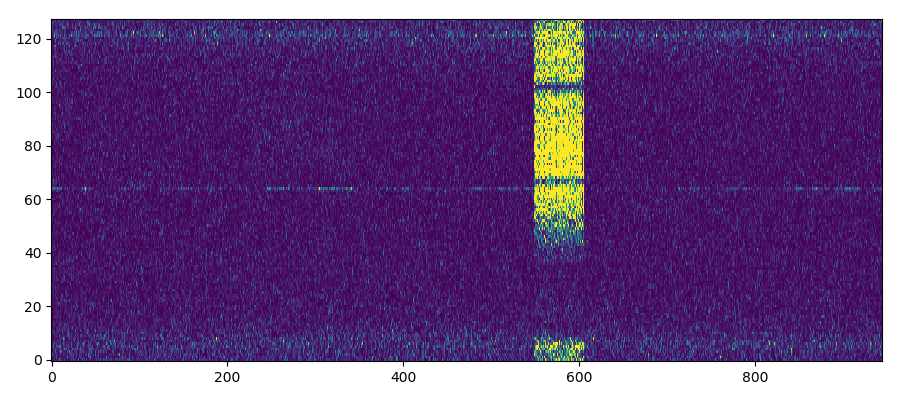

In [6]:
_, _, spectro_out = signal.spectrogram(oo, 1, nperseg=fft_points, return_onesided=False, detrend=False,
                               noverlap=0, window='hann')

# fftshift
spectro_out = np.roll(spectro_out, fft_points//2, axis=0)

# avg decimation
x = np.split(spectro_out, len(spectro_out) // freq_axis_avg_decimation)
golden_output = np.average(x, axis=1)

imshow(golden_output)

In [7]:
# orig_inp = load_iq('/home/gaspar/git/pyhacores/data/f2404_fs16.896_one_hop.iq')
# orig_inp = signal.decimate(orig_inp, 8)
# orig_inp *= 0.5

# # make sure input divides with fft_points
# orig_inp = np.array(orig_inp[:int(len(orig_inp) // fft_points) * fft_points])

# Golden output

<IPython.core.display.Javascript object>


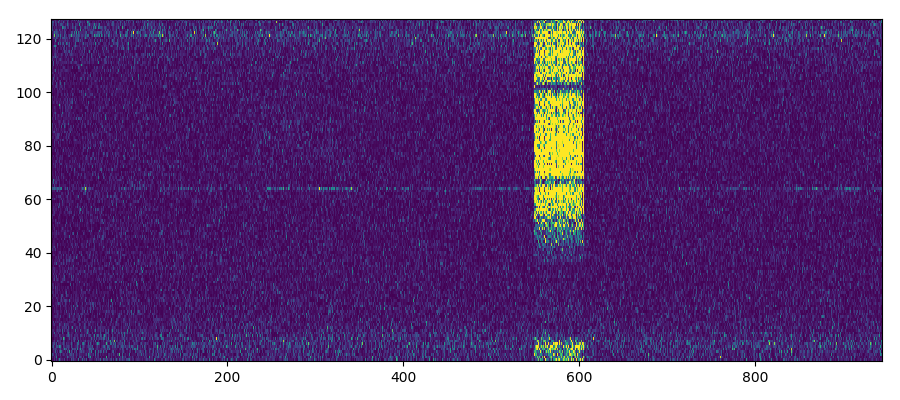

In [7]:
_, _, spectro_out = signal.spectrogram(orig_inp, 1, nperseg=fft_points, return_onesided=False, detrend=False,
                               noverlap=0, window='hann')

# fftshift
spectro_out = np.roll(spectro_out, fft_points//2, axis=0)

# avg decimation
x = np.split(spectro_out, len(spectro_out) // freq_axis_avg_decimation)
golden_output = np.average(x, axis=1)

imshow(golden_output)

# Packager

In [8]:
dut = Packager(fft_points)
sims = simulate(dut, orig_inp, output_callback=unpackage, simulations=sims)
assert sims_close(sims)

INFO:sim:Converting model to hardware types ...
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 241665/241665 [00:08<00:00, 27082.21it/s]


INFO:sim:OK!
INFO:sim:Simulations completed!
INFO:sim:sims_close(rtol=0.0001, atol=3.0517578125e-05)
INFO:sim:Using "MODEL" as golden output
INFO:sim:MODEL OK!
INFO:sim:PYHA OK!


In [9]:
snrs = snr(sims['MODEL'], sims['PYHA'])
print(f'Block AVG SNR: {snrs}')

Block AVG SNR: 48.8718801744892


# Apply windowing

In [10]:
dut = Windower(fft_points, coefficient_bits=8)

In [11]:
inp = np.array(sims['PYHA'])
sims = simulate(dut, inp, simulations=sims, output_callback=unpackage, input_callback=package)
assert hardware_sims_equal(sims)

INFO:sim:Converting model to hardware types ...
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 241665/241665 [00:10<00:00, 23623.74it/s]


INFO:sim:OK!
INFO:sim:Simulations completed!
INFO:sim:Testing hardware simulations equality...
INFO:sim:sims_close(rtol=1e-16, atol=1e-16)
INFO:sim:Using "PYHA" as golden output
INFO:sim:PYHA OK!


<IPython.core.display.Javascript object>


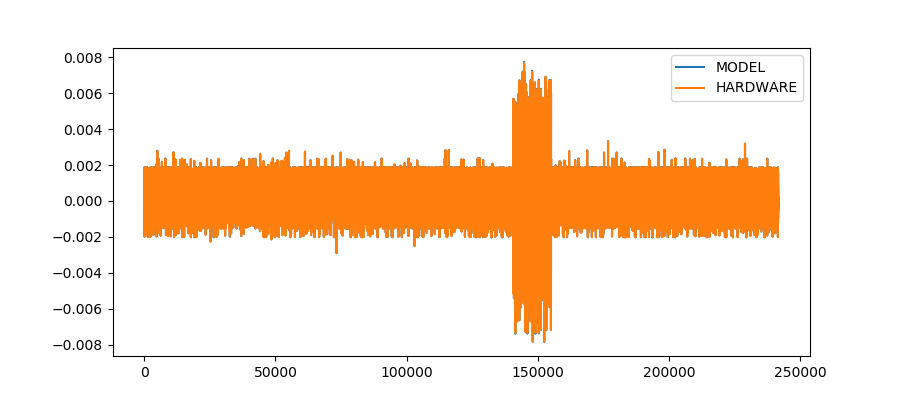

In [12]:
plt.plot(np.hstack(sims['MODEL']).real, label='MODEL')
plt.plot(np.hstack(sims['PYHA']).real, label='HARDWARE')
plt.legend()
plt.show()

In [13]:
snrs = snr(sims['MODEL'], sims['PYHA'])
print(f'Block AVG SNR: {snrs}')

Block AVG SNR: 38.966937805571824


# FFT

In [14]:
inp = np.array(sims['PYHA']) # input is the output of last block
dut = R2SDF(fft_points, twiddle_bits=10)
sims = simulate(dut, inp, simulations=sims, output_callback=unpackage, input_callback=package)
assert hardware_sims_equal(sims)

INFO:sim:Converting model to hardware types ...
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 241928/241928 [00:55<00:00, 4374.27it/s]


INFO:sim:OK!
INFO:sim:Simulations completed!
INFO:sim:Testing hardware simulations equality...
INFO:sim:sims_close(rtol=1e-16, atol=1e-16)
INFO:sim:Using "PYHA" as golden output
INFO:sim:PYHA OK!


<IPython.core.display.Javascript object>


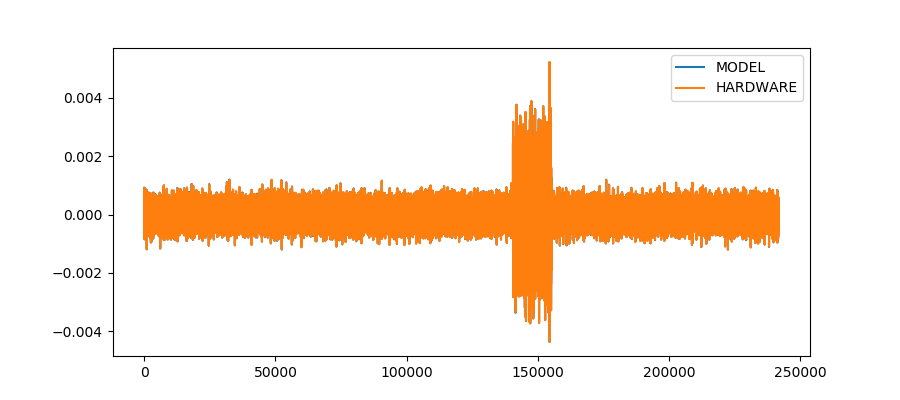

In [15]:
plt.plot(np.hstack(sims['MODEL']).real, label='MODEL')
plt.plot(np.hstack(sims['PYHA']).real, label='HARDWARE')
plt.legend()
plt.show()

In [16]:
snrs = snr(sims['MODEL'], sims['PYHA'])
print(f'Block AVG SNR: {snrs}')

Block AVG SNR: 28.391775016586642


# Magnitude

In [17]:
inp = np.array(sims['PYHA']) # input is the output of last block
dut = ConjMult()
sims = simulate(dut, inp, simulations=sims, output_callback=unpackage, input_callback=package)
assert hardware_sims_equal(sims)

INFO:sim:Converting model to hardware types ...
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 241665/241665 [00:11<00:00, 21756.54it/s]


INFO:sim:OK!
INFO:sim:Simulations completed!
INFO:sim:Testing hardware simulations equality...
INFO:sim:sims_close(rtol=1e-16, atol=1e-16)
INFO:sim:Using "PYHA" as golden output
INFO:sim:PYHA OK!


<IPython.core.display.Javascript object>


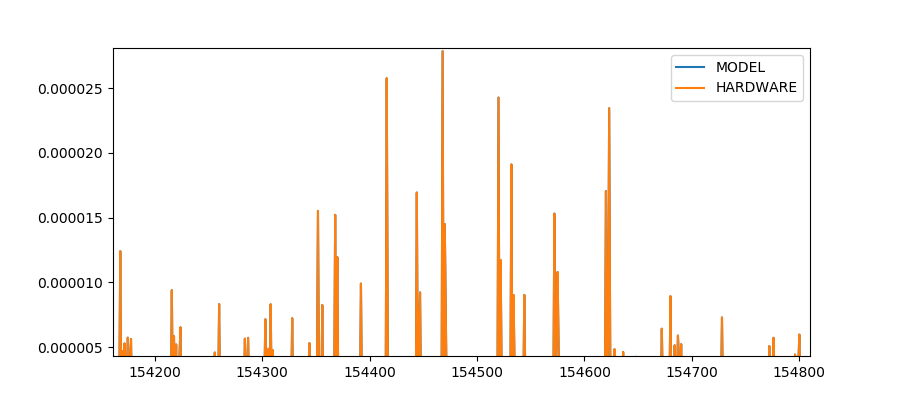

In [18]:
plt.plot(np.hstack(sims['MODEL']).real, label='MODEL')
plt.plot(np.hstack(sims['PYHA']).real, label='HARDWARE')
plt.legend()
plt.show()

In [19]:
snrs = snr(sims['MODEL'], sims['PYHA'])
print(f'Block AVG SNR: {snrs}')

Block AVG SNR: inf


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in double_scalars


# Decimation AVG

In [20]:
inp = np.array(sims['PYHA']) # input is the output of last block
dut = BitreversalFFTshiftDecimate(fft_points, freq_axis_avg_decimation)
sims = simulate(dut, inp, simulations=sims, output_callback=unpackage, input_callback=package)
assert hardware_sims_equal(sims)

INFO:sim:Converting model to hardware types ...
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...


[[1.92550942e-07 6.86268322e-08 1.19762262e-07 ... 1.00524630e-07
  6.03613444e-08 4.05998435e-08]
 [4.72937245e-08 1.29366526e-07 3.30473995e-07 ... 2.90980097e-07
  3.91126378e-07 4.55765985e-08]
 [4.04543243e-08 5.22122718e-08 2.00874638e-07 ... 2.11701263e-07
  3.39990947e-07 6.22239895e-08]
 ...
 [2.98605300e-08 1.41619239e-07 5.68688847e-08 ... 8.28003976e-08
  3.42639396e-07 1.20897312e-07]
 [1.22614438e-07 3.55939846e-08 6.53031748e-07 ... 4.72384272e-07
  2.69472366e-07 2.32248567e-08]
 [1.16124284e-07 5.79748303e-08 3.96685209e-07 ... 3.71946953e-08
  5.64003130e-07 5.83677320e-07]]


INFO:sim:Running "PYHA" simulation...


100%|██████████| 241921/241921 [00:09<00:00, 25476.28it/s]


INFO:sim:OK!
INFO:sim:Simulations completed!
INFO:sim:Testing hardware simulations equality...
INFO:sim:sims_close(rtol=1e-16, atol=1e-16)
INFO:sim:Using "PYHA" as golden output
INFO:sim:PYHA OK!


<IPython.core.display.Javascript object>


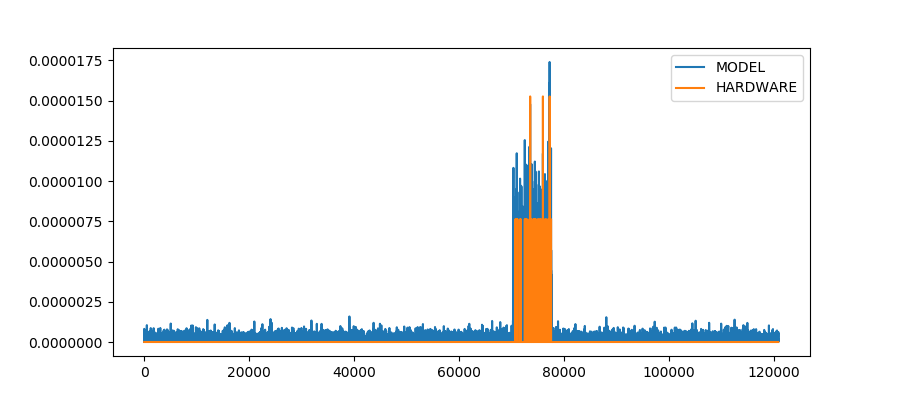

In [21]:
plt.plot(np.hstack(sims['MODEL']).real, label='MODEL')
plt.plot(np.hstack(sims['PYHA']).real, label='HARDWARE')
plt.legend()
plt.show()

In [25]:
snrs = snr(sims['MODEL'], sims['PYHA'])
print(f'Block AVG SNR: {snrs}')

Block AVG SNR: 1.9088494053679714


# Merged object

In [ ]:
inp = orig_inp
dut = Spectrogram(fft_points, decimate_by=freq_axis_avg_decimation)
full_sims = simulate(dut, inp, simulations=sims, output_callback=DataWithIndex._pyha_unpack)
assert hardware_sims_equal(sims)

In [ ]:
x = np.array(full_sims['PYHA']).T
imshow(x)

# Final evaluation

In [ ]:
x = np.array(sims['PYHA']).T
imshow(x)

In [ ]:
imshow(golden_output)

In [ ]:
flat_spectro = golden_output.flatten()
flat_spectro /= golden_output.max()

flat_pyha = x.flatten()
flat_pyha /= flat_pyha.max()

plt.plot(flat_spectro, label='MODEL_PYHA')
plt.plot(flat_pyha, label='HARDWARE')
plt.legend()
plt.show()

plt.plot(flat_pyha - flat_spectro, label='MODEL_PYHA')
plt.legend()
plt.show()

snrs = snr(flat_spectro, flat_pyha)
print(f'Block AVG SNR: {snrs}')
